# Synapses properties of a S1 cell

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
if 'DISPLAY' in os.environ:
    del os.environ['DISPLAY']
import sys

In [2]:
rootFolder = '/home/fernando/S1_BBP/'
os.chdir(rootFolder)

folder = os.listdir('cell_data/')
cellnumber=11
print(folder[cellnumber])

outFolder = rootFolder+'cell_data/'+folder[cellnumber]

durationstim = 200
delaystim = 70
timesimulation = 1000

with open(outFolder + '/current_amps.dat') as current_file:
    current_content = current_file.read()

print ('File content: %s' % current_content)
holding_current, step1_current, step2_current, step3_current = [float(x) for x in current_content.split()]

holding_current = 0  #
step3_current = 0  #

L5_UTPC_cADpyr232_3
File content: -0.069092 0.1764612 0.1911663 0.2058714


In [3]:
# !nrnivmodl mechanisms

In [4]:
def loadTemplateName(cellnumber): 
    outFolder = rootFolder+'cell_data/'+folder[cellnumber]
    f = open(outFolder+'/template.hoc', 'r')
    for line in f.readlines():
        if 'begintemplate' in line:
            templatename = str(line)     
    templatename=templatename[:-1]        
    templatename=templatename[14:]
    return templatename

cellName = folder[cellnumber]
cellTemplateName = loadTemplateName(cellnumber)

In [5]:
os.chdir(rootFolder)

from cellwrapper3 import loadCell
cell=loadCell(cellName, cellTemplateName)

soma = cell.soma[0]

	1 
	1 
	1 
cADpyr232_L5_UTPC_d736225429[0]


## Activating synapses
Now let's define an _in vivo_-like stimulus, where input neurons are firing like Poisson processes with presynaptic morphology type (mtype) specific rates.  

In [6]:
with open('synapses/mtype_map.tsv') as mtype_map_file:
    mtype_map_content = mtype_map_file.read()
    
mtype_map = {}
for line in mtype_map_content.split('\n')[:-1]:
    n, mtype = line.split()
    mtype_map[mtype] = int(n)
    
print (mtype_map)

{'L1_DAC': 0, 'L1_NGC-DA': 1, 'L1_NGC-SA': 2, 'L1_HAC': 3, 'L1_DLAC': 4, 'L1_SLAC': 5, 'L23_PC': 6, 'L23_MC': 7, 'L23_BTC': 8, 'L23_DBC': 9, 'L23_BP': 10, 'L23_NGC': 11, 'L23_LBC': 12, 'L23_NBC': 13, 'L23_SBC': 14, 'L23_ChC': 15, 'L4_PC': 16, 'L4_SP': 17, 'L4_SS': 18, 'L4_MC': 19, 'L4_BTC': 20, 'L4_DBC': 21, 'L4_BP': 22, 'L4_NGC': 23, 'L4_LBC': 24, 'L4_NBC': 25, 'L4_SBC': 26, 'L4_ChC': 27, 'L5_TTPC1': 28, 'L5_TTPC2': 29, 'L5_UTPC': 30, 'L5_STPC': 31, 'L5_MC': 32, 'L5_BTC': 33, 'L5_DBC': 34, 'L5_BP': 35, 'L5_NGC': 36, 'L5_LBC': 37, 'L5_NBC': 38, 'L5_SBC': 39, 'L5_ChC': 40, 'L6_TPC_L1': 41, 'L6_TPC_L4': 42, 'L6_UTPC': 43, 'L6_IPC': 44, 'L6_BPC': 45, 'L6_MC': 46, 'L6_BTC': 47, 'L6_DBC': 48, 'L6_BP': 49, 'L6_NGC': 50, 'L6_LBC': 51, 'L6_NBC': 52, 'L6_SBC': 53, 'L6_ChC': 54}


In [7]:
exc_cells = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 
             'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
             'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']
for mtype in mtype_map:
    if mtype in exc_cells:
        freq = 0.0 # [Hz]
    else:
        freq = 0.0 # [Hz]

In [8]:
parameters_name = {}

parameters_name[0] = 'synapse_id'
parameters_name[1] = 'pre_cell_id'
parameters_name[2] = 'pre_mtype'
parameters_name[3] = 'sectionlist_id'
parameters_name[4] = 'sectionlist_index'
parameters_name[5] = 'seg_x'
parameters_name[6] = 'synapse_type'
parameters_name[7] = 'dep'
parameters_name[8] = 'fac'
parameters_name[9] = 'use'
parameters_name[10] = 'tau_d'
parameters_name[11] = 'delay'
parameters_name[12] = 'weight'

In [9]:
with open('synapses/synapses.tsv') as mtype_map_file2:
    mtype_map_content2 = mtype_map_file2.read()

n = -1    
parameters_syn = {}
for line in mtype_map_content2.split('\n')[:-1]:
    if n < 0:
        nsynapses, nparameters = [int(x) for x in line.split()]        
        print (nsynapses, nparameters)
    else:
        n2 = 0
        parameters_list = line.split()   
        for parameter in parameters_list:
            if n2 < 7:
                prmtr = float(parameter)
                parameters_syn[n,parameters_name[n2]] = int(prmtr)
            else:
                parameters_syn[n,parameters_name[n2]] = float(parameter)
            n2 = n2 + 1
    n = n + 1

3 13


In [10]:
hotspot_synapses = []
hotspot_netcons  = []
hotspot_netstims = [] 

pre_mtypes_excinh = [] 

# for isynapse in range(nsynapses):
for isynapse in range(nsynapses):
    
#Create sectionref to the section the synapse will be placed on
    if parameters_syn[isynapse,'sectionlist_id'] == 0:
        cell.soma[parameters_syn[isynapse,'sectionlist_index']]      
#             sectionlist_name = "somatic"    
    elif parameters_syn[isynapse,'sectionlist_id'] == 1:
        cell.dend[parameters_syn[isynapse,'sectionlist_index']] 
#             sectionlist_name = "basal" 
    elif parameters_syn[isynapse,'sectionlist_id'] == 2:
        cell.apic[parameters_syn[isynapse,'sectionlist_index']]    
#             sectionlist_name = "apical" 
    elif parameters_syn[isynapse,'sectionlist_id'] == 3:
        cell.axon[parameters_syn[isynapse,'sectionlist_index']]     
#             sectionlist_name = "axonal"         
    else:
        print ("Sectionlist_id %d not support\n" % parameters_syn[isynapse,'sectionlist_index'])   

        
# If synapse_type < 100 the synapse is inhibitory, otherwise excitatory
    if parameters_syn[isynapse,'synapse_type'] > 100: ### it is oposit 
        #synapse_type_name = "inhibitory"
        hotspot_synapses.append(neuron.h.ProbGABAAB_EMS(parameters_syn[isynapse,'seg_x']))
        hotspot_netstims.append(neuron.h.NetStim())
        hotspot_netcons.append(neuron.h.NetCon(hotspot_netstims[isynapse],hotspot_synapses[isynapse]))
        
        hotspot_synapses[isynapse].tau_d_GABAA = parameters_syn[isynapse,'tau_d']
        hotspot_synapses[isynapse].tau_r_GABAA = 0.2   #rng.lognormal(0.2, 0.1)   
        hotspot_synapses[isynapse].tau_d_GABAB = 260.9
        hotspot_synapses[isynapse].tau_r_GABAB  = 3.5
        
        hotspot_synapses[isynapse].Use = parameters_syn[isynapse,'use']     
        hotspot_synapses[isynapse].Fac = parameters_syn[isynapse,'fac']     
        hotspot_synapses[isynapse].Dep = parameters_syn[isynapse,'dep']     

        hotspot_netcons[isynapse].weight[0] = parameters_syn[isynapse,'weight'] # strength of the synapse
        hotspot_netcons[isynapse].delay = parameters_syn[isynapse,'delay'] 
        hotspot_netstims[isynapse].number   = 9e9 # number of synaptic activation
        hotspot_netstims[isynapse].noise    = 1   # randomness
        hotspot_netstims[isynapse].interval = 200  # mean time between spikes |200 ms = 5 Hz|
        hotspot_netstims[isynapse].start = 0
        
    else:
        #synapse_type_name = "excitatory"
        hotspot_synapses.append(neuron.h.ProbAMPANMDA_EMS(parameters_syn[isynapse,'seg_x']))
        hotspot_netstims.append(neuron.h.NetStim())
        hotspot_netcons.append(neuron.h.NetCon(hotspot_netstims[isynapse],hotspot_synapses[isynapse]))
        
        hotspot_synapses[isynapse].tau_d_AMPA = parameters_syn[isynapse,'tau_d']  
        hotspot_synapses[isynapse].tau_r_AMPA = 0.2
        hotspot_synapses[isynapse].tau_r_NMDA = 0.29
        hotspot_synapses[isynapse].tau_d_NMDA = 43        
        
        hotspot_synapses[isynapse].Use = parameters_syn[isynapse,'use']     
        hotspot_synapses[isynapse].Fac = parameters_syn[isynapse,'fac']     
        hotspot_synapses[isynapse].Dep = parameters_syn[isynapse,'dep']          
        
        hotspot_netcons[isynapse].weight[0] = parameters_syn[isynapse,'weight'] # strength of the synapse
        hotspot_netcons[isynapse].delay = parameters_syn[isynapse,'delay'] 
        hotspot_netstims[isynapse].number   = 9e9 # number of synaptic activation
        hotspot_netstims[isynapse].noise    = 1   # randomness
        hotspot_netstims[isynapse].interval = 1000  # mean time between spikes |1000 ms = 1 Hz|
        hotspot_netstims[isynapse].start = 0
        

Changed dt


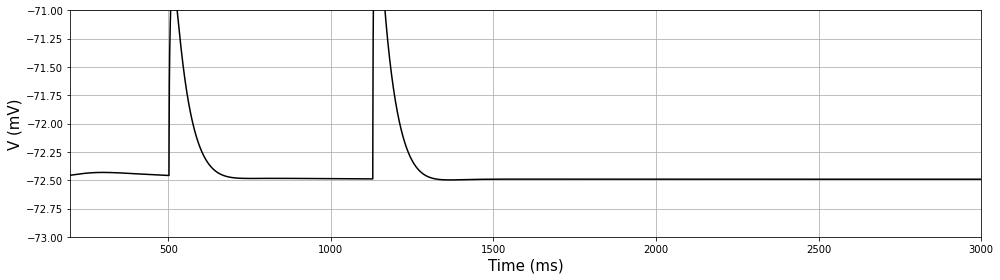

In [13]:
timesimulation = 3000
plotvt(timesimulation)

In [ ]:
timesimulation = 3000
plotvt(timesimulation)

In [ ]:
hotspot_synapses[isynapse].Dep = 138.0
hotspot_synapses[isynapse].Fac = 670.0
timesimulation = 10300
plotvt(timesimulation)

In [12]:
def plotvt(timesimulation):
    
    neuron.h.dt = 0.05
    neuron.h.cvode_active(0)
    neuron.h.tstop = timesimulation # ms

    time = neuron.h.Vector()
    voltage = neuron.h.Vector()
    ik = neuron.h.Vector()


    time.record(neuron.h._ref_t)
    voltage.record(soma(.5)._ref_v);
    ik.record(soma(.5)._ref_ik);

    neuron.h.run()
    
    fontsiz=15
    timeRange = [199, timesimulation]
    ylim = [-73, -71]
    figSize = (14,4)
    fig = plt.figure(figsize=figSize)  

    plt.ylabel('V (mV)', fontsize=fontsiz)
    plt.xlabel('Time (ms)', fontsize=fontsiz)
    plt.plot(time,voltage, 'k')
    plt.xlim(timeRange)
    plt.ylim(ylim)
    plt.grid(True)
    plt.ion()
    plt.tight_layout()
    plt.show()